<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_fastai_xla_extensions_Pets_GPU_with_batch_tfms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI XLA Extensions Pets  Comparison Demo
Same as GPU Comparison except batch_tfms enabled


## How to use

### Configure the Pytorch XLA package 

The Pytorch xla package requires an environment supporting TPUs (Kaggle kernels, GCP or Colab environments required)

If running on Colab, make sure the Runtime Type is set to TPU.


In [1]:
#hide_input
#colab
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash 

Updating fastai...
Done.


Dont run for GPU

In [3]:
#hide_output
#colab
# !pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

Install fastai and the fastai_xla_extensions packages

In [4]:
#hide_output
#colab
!pip install -Uqq fastai --upgrade 

In [5]:
#hide_output
#ci
# !pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions

In [6]:
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
fastai==2.1.9
fastcore==1.3.12
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


### Import the libraries
Import the fastai and fastai_xla_extensions libraries

In [7]:
from fastai.vision.all import *
# import fastai_xla_extensions.core

### Example
Build a Pets classifier - adapted from fastai course [Lesson 5 notebook](https://github.com/fastai/course-v4/blob/master/nbs/05_pet_breeds.ipynb)

Load Oxford-IIT Pets dataset

In [8]:
#colab
path = untar_data(URLs.PETS)/'images'

In [9]:
Path.BASE_PATH = path

In [10]:
pat = r'(.+)_\d+.jpg$'

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [11]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(pat),'name'),
    item_tfms=Resize(224),
    # batch_tfms=[]
    batch_tfms=aug_transforms(size=224,min_scale=0.75)
)

In [12]:
#colab
datablock.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pomeranian_97.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x334
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pomeranian_97.jpg
    applying partial gives
      pomeranian
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(28)

Final sample: (PILImage mode=RGB size=500x334, TensorCategory(28))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item

Create the dataloader

In [13]:
dls = datablock.dataloaders(path,bs=256)

In [14]:
#colab
dls.device

device(type='cuda', index=0)

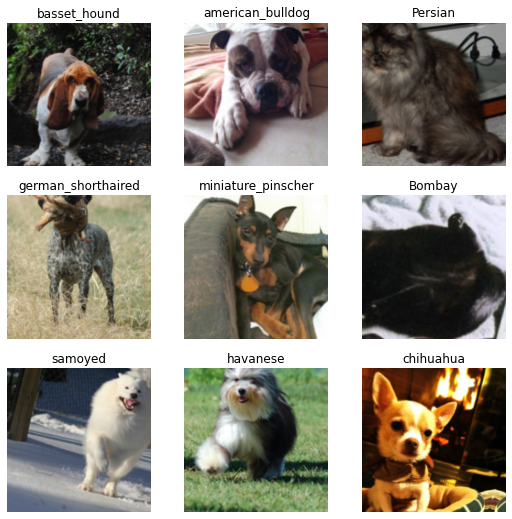

In [15]:
#colab
dls.show_batch()

Create a Fastai CNN Learner

In [16]:
#colab
learner = cnn_learner(dls, resnet34, metrics=accuracy)
                      

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Using the `lr_find` works 

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.004365158267319202)

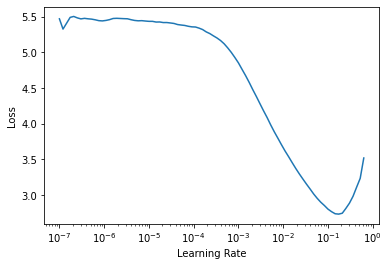

In [17]:
#colab
learner.lr_find()

Fine tune model


In [18]:
%%time
#colab
learner.fine_tune(6,base_lr=9e-3,freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,2.629322,0.450489,0.848444,00:54
1,1.314515,0.342060,0.890392,00:53
2,0.833928,0.335160,0.896482,00:53
3,0.606379,0.313262,0.901894,00:53


epoch,train_loss,valid_loss,accuracy,time
0,0.314860,0.523038,0.857239,00:56
1,0.334219,0.896849,0.799729,00:56
2,0.340859,0.808597,0.827470,00:56
3,0.291984,0.564770,0.863329,00:56
4,0.224408,0.313185,0.911367,00:56
5,0.163449,0.315136,0.911367,00:56


CPU times: user 2min 7s, sys: 1min 38s, total: 3min 45s
Wall time: 9min 14s


In [19]:
learner.save('stage-1')

Path('models/stage-1.pth')

Unfreeze the model

In [20]:
#colab
learner.unfreeze()

Run the LR Finder again. 

_(Something wrong with the results. Still need to debug this.)_

CPU times: user 32 s, sys: 26.6 s, total: 58.6 s
Wall time: 2min 1s


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

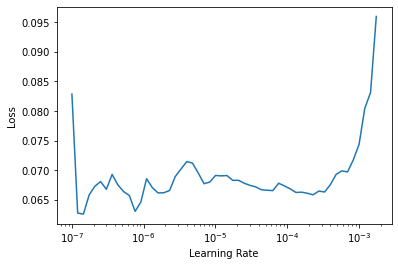

In [21]:
%%time
#colab
learner.lr_find()

Further fine-tuning

In [22]:
%%time
#colab
learner.fit_one_cycle(6,slice(3e-7,2e-5),wd=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.075544,0.312016,0.910690,00:56
1,0.071464,0.313512,0.909337,00:56
2,0.068358,0.315418,0.907984,00:57
3,0.068771,0.312827,0.912043,00:56
4,0.069776,0.313317,0.912720,00:56
5,0.067109,0.318325,0.909337,00:56


CPU times: user 1min 22s, sys: 1min 8s, total: 2min 30s
Wall time: 5min 38s


In [23]:
#hide
#colab
learner.save('stage-2')

Path('models/stage-2.pth')

In [24]:
#hide
#colab
learner.load('stage-2')

Model params are using TPU

In [25]:
#colab
list(learner.model.parameters())[0].device

device(type='cuda', index=0)

Plot loss seems to be working fine.

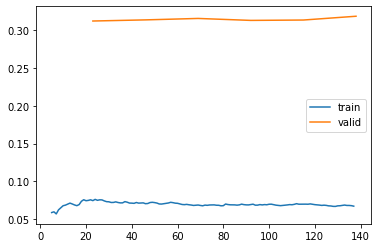

In [26]:
#colab
learner.recorder.plot_loss()

In [27]:
interp = ClassificationInterpretation.from_learner(learner)

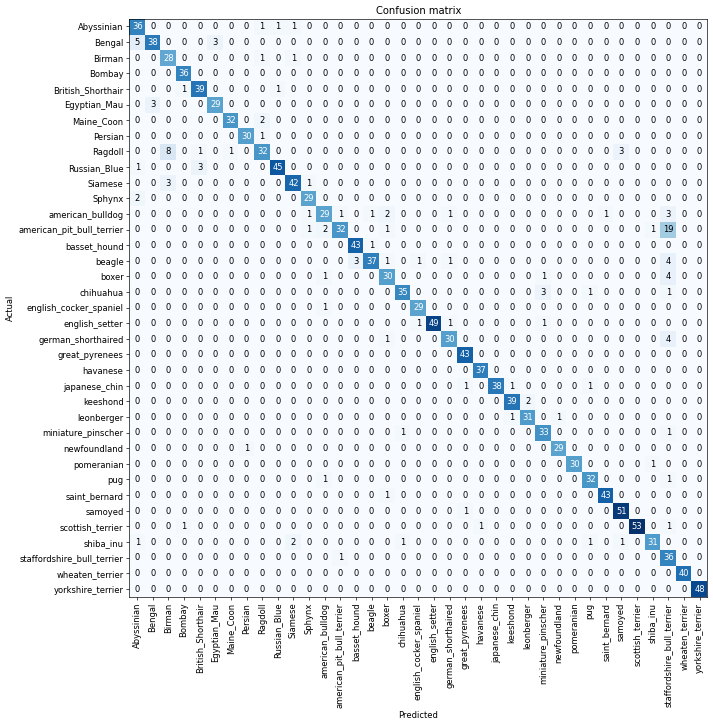

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
interp.most_confused(4)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 19),
 ('Ragdoll', 'Birman', 8),
 ('Bengal', 'Abyssinian', 5),
 ('beagle', 'staffordshire_bull_terrier', 4),
 ('boxer', 'staffordshire_bull_terrier', 4),
 ('german_shorthaired', 'staffordshire_bull_terrier', 4)]

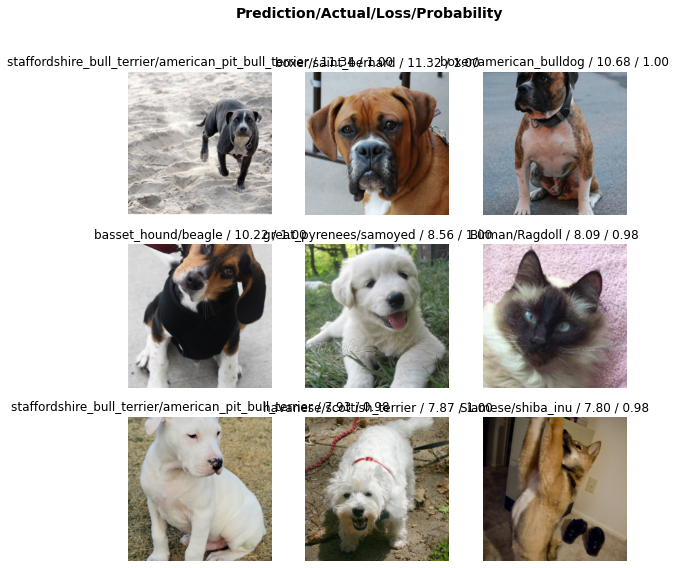

In [30]:
interp.plot_top_losses(9)

In [31]:
learner.export()

In [32]:
# from google.colab import drive
# drive.mount('/content/drive')

In [33]:
# !mkdir -p /content/drive/MyDrive/fastai_v4/fastai_xla_extensions/pets/models
# !cp /content/models/*.pth /content/drive/MyDrive/fastai_v4/fastai_xla_extensions/pets/models/.
# !cp export.pkl /content/drive/MyDrive/fastai_v4/fastai_xla_extensions/pets/models/.